In [1]:
import collections
import datetime
import math

import os
# import sys
import time

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import gc

pd.options.display.float_format = "{:.2f}".format
# plt.rcParams.update({'font.size': 18})
format = '%d/%m/%Y %H:%M'

# Load data

Load all data required.

In [2]:
# All tracks
data_path = os.getcwd() + '\\data\\processed\\10_results.pkl'
txt = 'Results - ' + data_path

if os.path.exists(data_path):
    print('Loaded: ' + txt)
    with open(data_path, 'rb') as f:
        results = pickle.load(f)
else:
    with open(data_path, 'wb') as f:
        pickle.dump(results, f)

results['(1-error)/rt'] = (1 - results['error']) / results['run_time']

# results = results.reset_index()
print(len(results))

Loaded: Results - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\10_results.pkl
7995


# Results and conclusions

In [3]:
# results.head()
df = results.pivot_table(index=['method', 'frac'],
                         aggfunc=['mean', 'median', 'std', 'min', 'max'],
                         values=['error', 'run_time', '(1-error)/rt'])
# df

summ = results.pivot_table(index=['method'],
                           aggfunc=['mean', 'median', 'std', 'min', 'max'],
                           values=[
                               'total_tracks', 'selected_tracks', 'matches',
                               'error', 'run_time', '(1-error)/rt'
                           ])
# summ

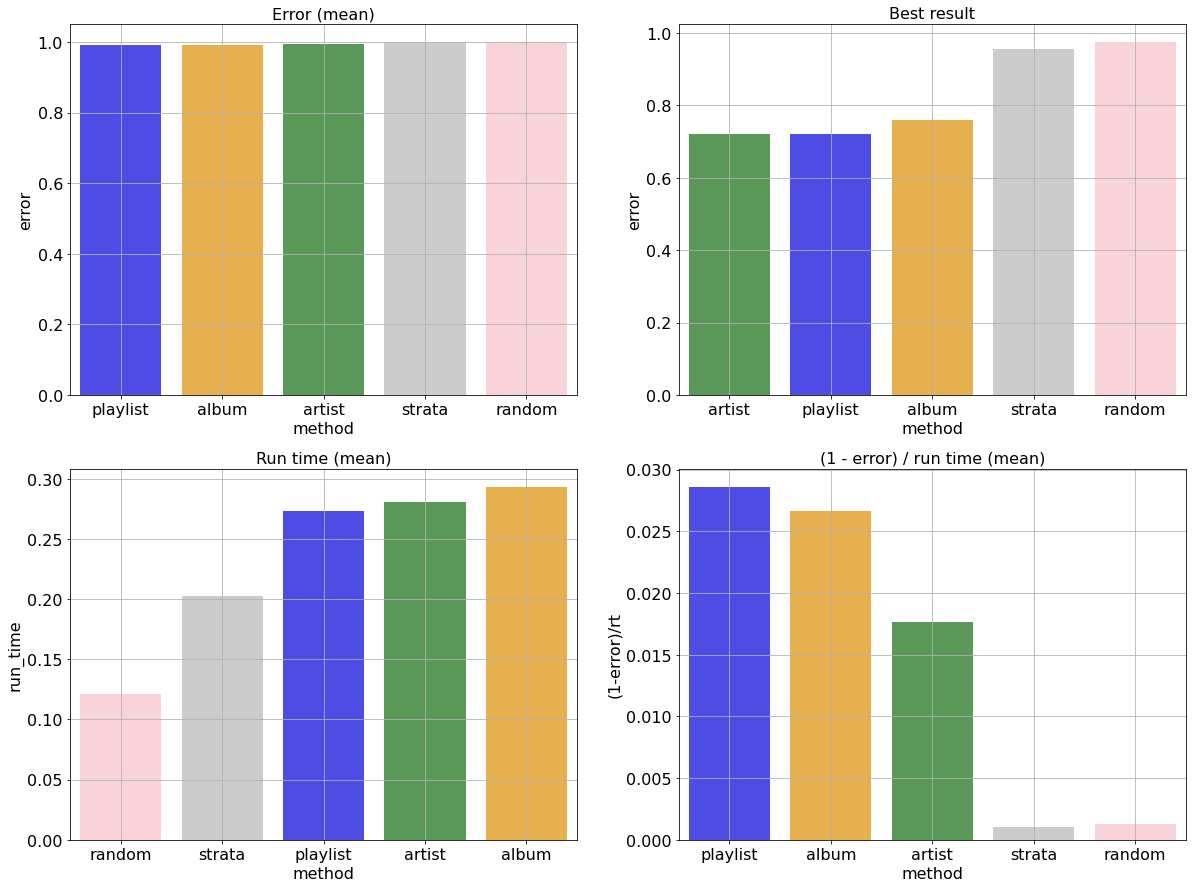

In [4]:
d = summ['mean'].sort_values(by='error', ascending=True).reset_index()
r = summ['mean'].sort_values(by='run_time', ascending=True).reset_index()
m = summ['min'].sort_values(by='error', ascending=True).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

ys = ['error', 'error', 'run_time', '(1-error)/rt']
ds = [d, m, r, d]
ts = [
    'Error (mean)', 'Best result', 'Run time (mean)',
    '(1 - error) / run time (mean)'
]

i = 0
for r in [0, 1]:
    for c in [0, 1]:
        axes[r, c].set_xlabel('', fontsize=16)
        axes[r, c].set_ylabel('', fontsize=16)
        axes[r, c].tick_params(labelsize=16)

        sns.barplot(ax=axes[r, c],
                    x='method',
                    y=ys[i],
                    data=ds[i],
                    palette={
                        'playlist': 'blue',
                        'album': 'orange',
                        'artist': 'forestgreen',
                        'strata': 'silver',
                        'random': 'pink'
                    },
                    alpha=0.8).set_title(ts[i], fontsize=16)
        axes[r, c].grid()
        i = i + 1

data_path = os.getcwd() + '\\data\\6_model_perf.png'
plt.savefig(data_path, bbox_inches='tight')

- **Model Performance**
    - The recommendation system using the **playlist** and the **album** to suggest a new track tied in the lead with an error of 99.13% and 99.16%, respectively
    - The best result for a single run was achieved by the models **playlist** and the **artist** with 72% of error
    
    
- **Run time and performance**
     - As expected, the random model is the fastest; however, the other models are not so complex, and the time for each run is short
     - Even being slower than the random model, the **playlist** based model had the best accuracy per unit of time to run


A recommendation system is not a minimal problem. It has multiple dimensions that can be explored and the models proposed here are pretty simple, just considering one feature at each time. The only "ranking" criteria adopted was the recurrence of a given track.

The performance of the models is far from good, but they showcase that this is a direction that could be explored by using users' knowledge by selecting their playlists and the songs' features.

Possible approaches to improving the models' performance include ranking and combining multiple features. But we must keep in mind that this will increase the time required to train the model and generate the results. Then we must tune our decisions based on the requirements of a real-time solution or something else that can be prepared off-line.

Below are presented the histograms and boxplots for all sets of fractions used as seeds and models.
The only finding that we can highlight is the apparent slightly better performance of models that used only 25% of the tracks as seed.
However, a conclusive answer requires some statistical analysis to evaluate if this is an effect of sampling size or a consequence of the initial condition.

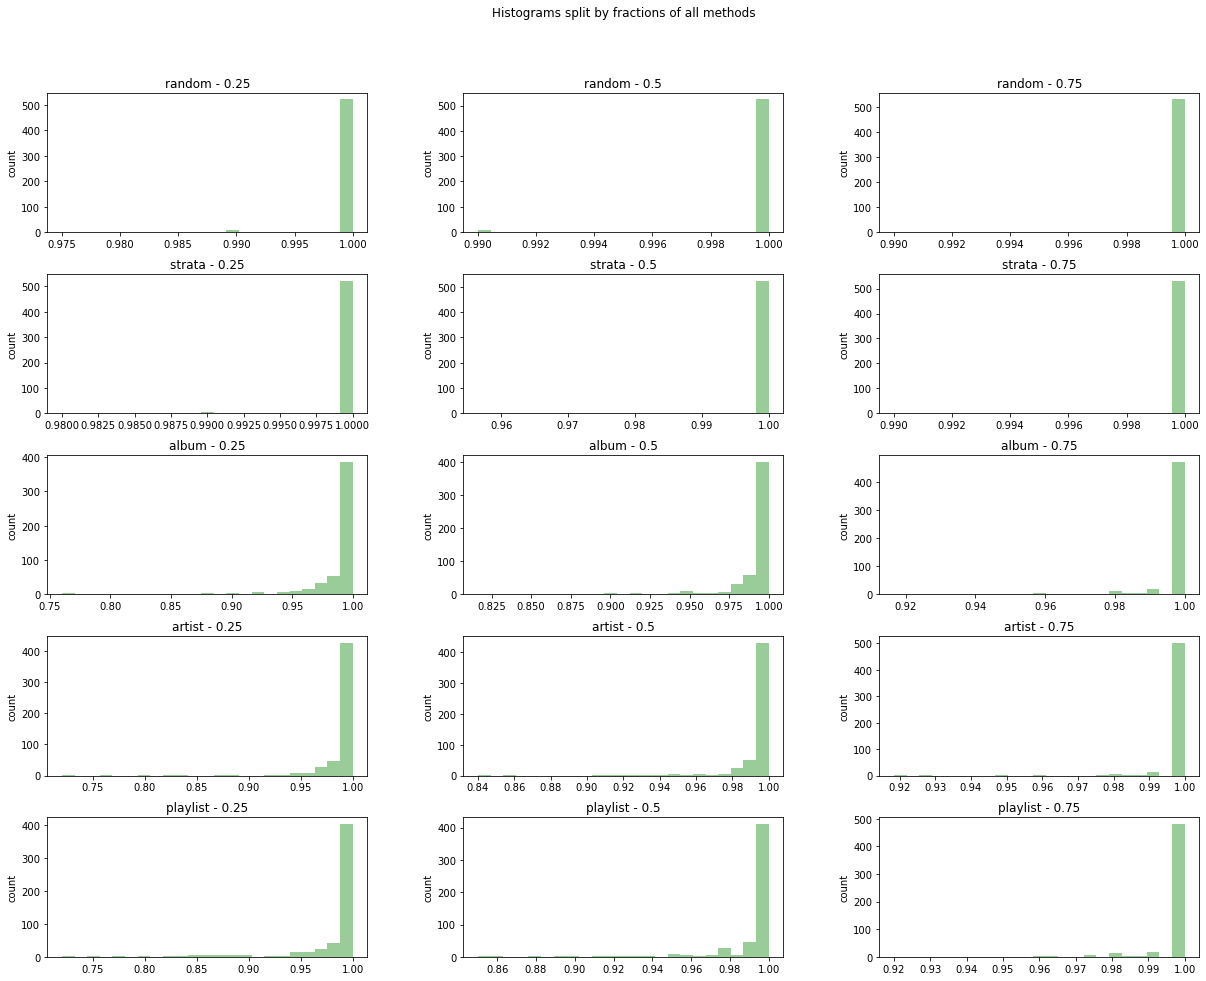

In [5]:
fig = plt.figure(figsize=(20, 15))
plt.suptitle('Histograms split by fractions of all methods')
rows = 5
cols = 3

ax_array = fig.subplots(rows, cols)
n_bins = 23
df = results
for y, frac in enumerate([.25, .5, .75]):
    for x, method in enumerate(
        ['random', 'strata', 'album', 'artist', 'playlist']):
        ax = ax_array[x, y]
        ax.title.set_text(method + ' - ' + str(frac))
        data = df[(df['method'] == method)
                  & (results['frac'] == frac)]['error']

        ax.hist(data, bins=n_bins, color='green', alpha=0.4)
        y_bottom, y_top = ax.get_ylim()
        ax.set_ylabel('count')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)

data_path = os.getcwd() + '\\data\\7_model_perf_hist.png'
plt.savefig(data_path, bbox_inches='tight')

plt.show()

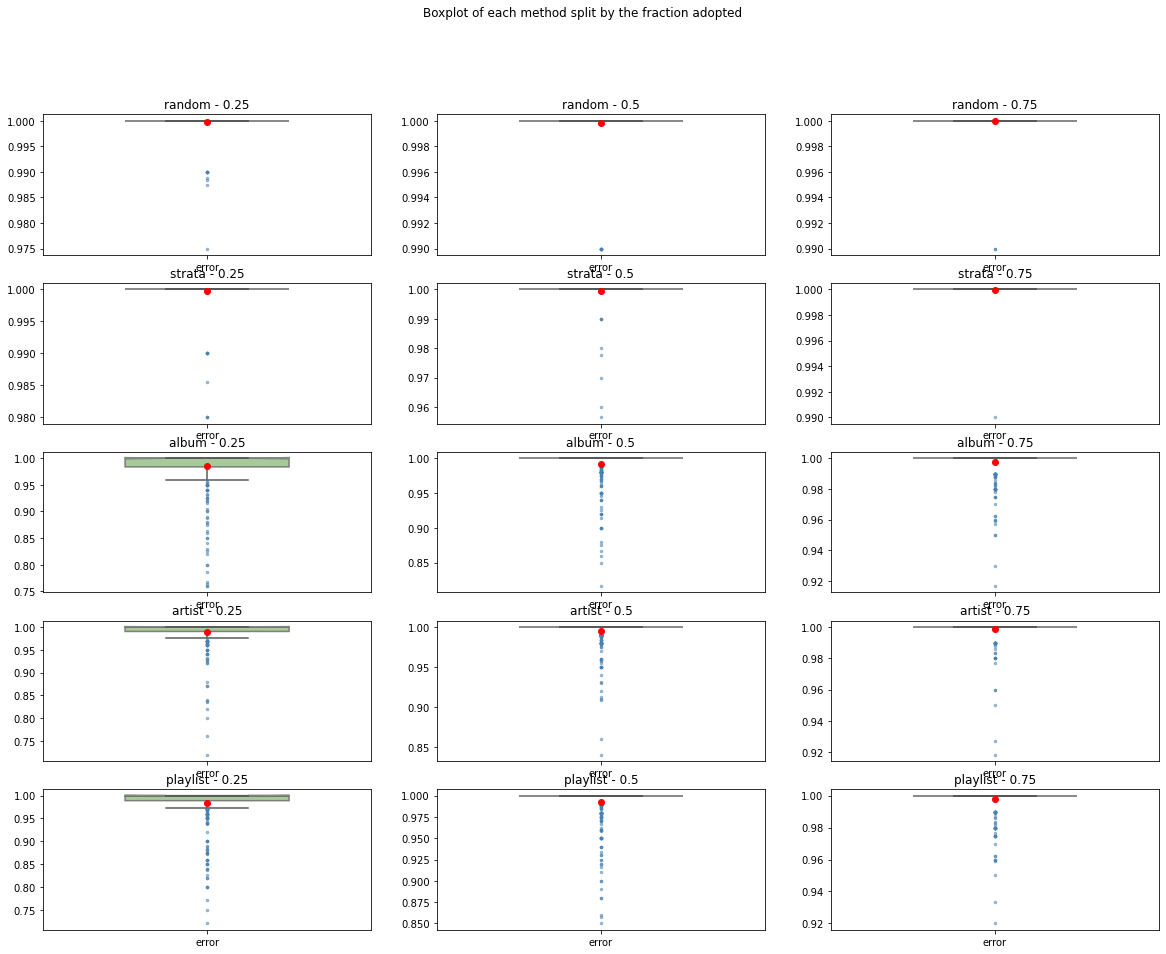

In [6]:
rows = 5
cols = 3

df = results

fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 15))
fig.suptitle('Boxplot of each method split by the fraction adopted')

for x, method in enumerate(['random', 'strata', 'album', 'artist',
                            'playlist']):
    for y, frac in enumerate([.25, .5, .75]):
        df1 = df[(df['method'] == method)
                 & (results['frac'] == frac)][['error']]

        sns.boxplot(ax=axes[x, y],
                    data=df1,
                    palette='summer_r',
                    showmeans=True,
                    meanprops={
                        "marker": "o",
                        "markerfacecolor": "red",
                        "markeredgecolor": "red"
                    },
                    flierprops=dict(marker='.',
                                    markerfacecolor='steelblue',
                                    markeredgecolor='steelblue',
                                    alpha=.5),
                    boxprops=dict(alpha=.7),
                    width=.5,
                    notch=True).set_title(method + ' - ' + str(frac))

# Statistical summary of the numerical columns
# summ = df.describe().transpose()
# summ
data_path = os.getcwd() + '\\data\\8_model_perf_box.png'
plt.savefig(data_path, bbox_inches='tight')